In [110]:
import numpy as np
from os.path import isfile

from skimage.io import imread
from skimage import measure


from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
def find_files_like(datapath, startswith, endswith='.npz'):
    from os import listdir
    
    # look for file in folder `datapath` that starts with `startswith`
    filename = []
    for file in listdir(datapath):
        if file.startswith(startswith) and file.endswith(endswith):
            filename.append(file)
    
    return filename

In [27]:
def calc_shape(img):
    # get components of the centroid
    M = measure.moments(img, 1)
    xm = M[0, 1] / M[0, 0]
    ym = M[1, 0] / M[0, 0]
    
    # size
    size = M[0, 0]
    
    # get centralized moments
    mu = measure.moments_central(img, xm, ym)
    muprime = mu / size
    
    # covariance matrix
    cov = np.array([[muprime[2, 0], muprime[1, 1]], [muprime[1, 1], muprime[0, 2]]])
    
    # eigenvalues and eigenvectors
    w, v = np.linalg.eig(cov)
    
    # orientation
    if muprime[2, 0] != muprime[0, 2]:
        theta = np.arctan2(2 * muprime[1, 1], muprime[2, 0] - muprime[0, 2]) / 2
    else:
        raise ValueError("Can't compute `theta` because mu'_20 == mu'_02")
        
    # eccentricity
    ecc = np.sqrt(1.0 - np.min(w) / np.max(w))
    
    return size, theta, ecc, v

In [28]:
secondsightpath = "/home/mbeyeler/data/secondsight/shape/TB/20090311/VID1545/"
img_gt = imread(secondsightpath + "VID1545.AVI.429-445_shape.bmp", as_grey=True)

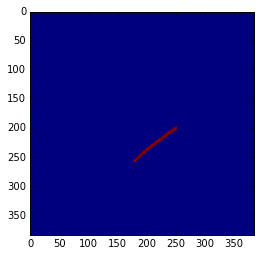

In [29]:
plt.imshow(img_gt)

In [126]:
def find_bitmaps(folder, electrodes=[], amps=[]):
    # Given a list of electrodes and amplitude values, finds the corresponding
    # bitmap files in `folder`
    import pandas as pd
    
    if not folder.endswith('/'):
        folder += '/'
    
    # Open file
    files = find_files_like(folder, 'VIDFileListNew_', '.xls')
    if not files:
        raise ValueError('Could not find file')
    else:
        file = files[0]

    # Parse file
    xl = pd.ExcelFile(folder + file)
    df = xl.parse(xl.sheet_names[0])  # assume Sheet 1
    assert 'electrode' in df.columns
    assert 'amplitude' in df.columns
    
    if electrodes and amps:
        # Find rows with right electrodes and amplitude values
        col_el = '_'.join(electrodes)
        col_amp = '_'.join(amps) + '_'
        rows = df.loc[(df['electrode'] == col_el) & (df['amplitude'] == col_amp)]
    else:
        rows = df
    
    return [folder + bmp_folder + '/' + bmp_file
            for bmp_folder, bmp_file in zip(rows['foldername'], rows['filename'])]

In [130]:
datafolder = '/home/mbeyeler/data/secondsight/shape/TB/20090318'
files = find_bitmaps(datafolder, ['L4'], ['2'])
print('Found %d files' % len(files))

Found 5 files


/home/mbeyeler/data/secondsight/shape/TB/20090318/VID1555/VID1555.AVI.699-730_shape.bmp
/home/mbeyeler/data/secondsight/shape/TB/20090318/VID1555/VID1555.AVI.3491-3554_shape.bmp
/home/mbeyeler/data/secondsight/shape/TB/20090318/VID1555/VID1555.AVI.4299-4344_shape.bmp
/home/mbeyeler/data/secondsight/shape/TB/20090318/VID1555/VID1555.AVI.5832-5875_shape.bmp
/home/mbeyeler/data/secondsight/shape/TB/20090318/VID1555/VID1555.AVI.11600-11640_shape.bmp


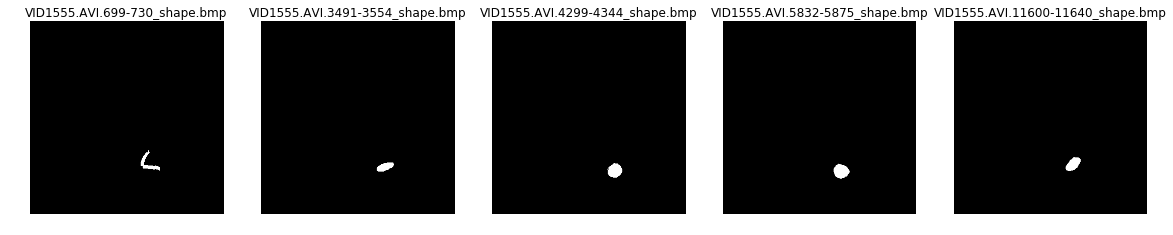

In [131]:
plt.figure(figsize=(20, 10))
for i, f in enumerate(files):
    plt.subplot(1, len(files), i + 1)
    if not isfile(f):
        print('Could not find file "' + f + '"')
        continue
    else:
        print(f)

    img = imread(f, asgrey=True)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f.split('/')[-1])

In [ ]:
# Load simulated data

datapath = '/home/mbeyeler/data/shape/lambda8.0/'
prefix = 'TB-20090311'

name_E1 = ['L1', 'L1', 'L2', 'L2', 'L2', 'M2', 'M3', 'M3', 'M4', 'M4']
name_E2 = [None, 'M2', None, 'M3', 'M4', None, None, 'L2', None, 'L2']

all_amp1 = []
all_amp2 = []
all_gamma = []
all_labels = []
for E1, E2 in zip(name_E1, name_E2):
    print('(%s, %s):' % (E1, E2))
    if E1 != 'L2' or E2 is not None:
        continue
    
    # Load data from file, auto-complete file name
    filestr = '%s_%s_%s_' % (prefix, E1, E2)
    filenames = find_files_like(datapath, filestr)
    
    filename = ''
    if not filenames:
        print(' - Could not locate any files with "' + datapath + filestr + '*", skip')
        continue
    else:
        if len(filenames) > 1:
            print(' - Found multiple files: ' + filenames + ", skip")
            continue
        else:
            filename = filenames[0]
            print(' - Loading file ' + filename)

    assert filename
    exp_data = np.load(datapath + filename)
    data = exp_data['data'][()]
    exp_params = exp_data['exp_params'][()]
    
    frame = data['cond1']['frames'][0]
    
    break

In [ ]:
exp_params

In [ ]:
data

In [ ]:
img = data['cond1']['frames'][0].data
# img.resize(img_gt.shape)

In [ ]:
plt.imshow(img, cmap='gray')
plt.colorbar()

In [ ]:
from skimage.filters import threshold_otsu

In [ ]:
img_th = np.double(img >= threshold_otsu(img))
plt.imshow(img_th, cmap='gray')

In [ ]:
def get_shape(img):
    from skimage import measure
    
    # get components of the centroid
    M = measure.moments(img, 1)
    xm = M[0, 1] / M[0, 0]
    ym = M[1, 0] / M[0, 0]
    
    # size
    size = M[0, 0]
    
    # get centralized moments
    mu = measure.moments_central(img, xm, ym)
    muprime = mu / size
    
    # covariance matrix
    cov = np.array([[muprime[2, 0], muprime[1, 1]], [muprime[1, 1], muprime[0, 2]]])
    
    # eigenvalues and eigenvectors
    w, v = np.linalg.eig(cov)
    
    # orientation
    if muprime[2, 0] != muprime[0, 2]:
        theta = np.arctan2(2 * muprime[1, 1], muprime[2, 0] - muprime[0, 2]) / 2
    else:
        raise ValueError("Can't compute `theta` because mu'_20 == mu'_02")
        
    # eccentricity
    ecc = np.sqrt(1.0 - np.min(w) / np.max(w))
    
    return size, theta, ecc, v

In [ ]:
size, theta, ecc, v = calc_shape(img_th)
print("size = %f" % size)
print("theta = %f" % theta)
print("ecc = %f" % ecc)
print(v)

In [ ]:
somedata = np.array([129.836695, 144.342894,
126.156071, 138.710835,
122.804838, 133.122378,
119.412190, 127.832710,
117.475217, 122.539631,
115.467121, 117.961357,
114.330993, 113.970480,
113.820338, 110.484653,
113.528555, 108.384540,
113.926964, 106.748398,
114.385891, 105.370056,
115.476950, 103.793789,
116.383220, 103.015024,
117.791370, 102.769981,
120.357624, 101.306517,
123.237776, 100.613620,
126.429082, 100.874999,
129.685168, 102.217229,
134.117523, 104.179212,
138.621149, 106.748122,
143.627730, 110.524278,
147.927741, 115.296489,
152.599995, 120.081304,
157.359470, 125.534619,
162.399389, 132.051766,
167.566915, 138.203712,
172.338287, 143.992906,
176.444568, 149.587527,
178.903415, 154.230750,
180.097119, 158.289657,
180.118137, 161.444815,
178.902918, 163.912997,
176.632936, 165.851070,
172.841956, 166.827467,
168.853294, 167.305117,
163.419197, 166.481381,
155.903542, 164.266705,
149.340466, 160.596902,
142.897711, 157.132908,
138.089260, 154.115953,
134.156597, 151.629067,
132.266248, 150.549946]).reshape((-1, 2))

In [ ]:
for i in range(1, somedata.shape[0]):
    plt.plot(somedata[i - 1:i + 1, 0], somedata[i-1:i+1:1, 1], 'k')
plt.plot(somedata[[-1, 0], 0], somedata[[-1, 0], 1], 'k')
plt.axis('equal')

In [ ]:
from skimage.draw import polygon

In [ ]:
rr, cc = polygon(somedata[:, 0] - np.min(somedata[:, 0]), somedata[:, 1] - np.min(somedata[:, 1]))
img = np.zeros_like(img_th)
img[rr, cc] = 1

In [ ]:
plt.imshow(np.fliplr(img), cmap='gray')

In [ ]:
size, theta, ecc, v = calc_shape(img_th)
print("size = %f" % size)
print("theta = %f" % theta)
print("ecc = %f" % ecc)
print(v)